# Experiment 3a: Steering at Thought Anchors (KL vs. beta)

This notebook loads:
- an annotated example with a thought anchor,
- the corresponding steering vector computed in `experiments/find_steering_vectors.py`,

and measures how the next-token distribution changes when we steer activations
at the layer and position just before the anchor sentence. We sweep steering amplitude
`beta` in [-1, 1] and compute KL divergence vs. the unsteered baseline.

In [32]:
import os, json, math
from typing import List, Dict

import torch
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))
from utils import load_model_and_vectors, split_solution_into_chunks

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

In [33]:
# Config
model_name = 'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B'
model_tag = model_name.replace('/', '-')
from pathlib import Path
# Find repo root by searching upwards for 'generated_data' (fallback: cwd)
cwd = Path.cwd()
repo_root = next((p for p in [cwd] + list(cwd.parents) if (p / 'generated_data').exists()), cwd)
# Build absolute paths to the generated_data files
annotated_path = repo_root / 'generated_data' / f'generated_data_annotated_{model_tag}.json'
vectors_path = repo_root / 'generated_data' / f'steering_vectors_{model_tag}.json'
example_index = 0  # change to pick a different example

# Steering amplitudes to test
betas = np.linspace(-10.0, 10.0, 9)  # [-1, -0.75, ..., 0.75, 1]
betas

array([-10. ,  -7.5,  -5. ,  -2.5,   0. ,   2.5,   5. ,   7.5,  10. ])

In [34]:
# Load model/tokenizer
model, tokenizer, _ = load_model_and_vectors(model_name=model_name, compute_features=False, device=device)
model.model.eval()

# Load data
with open(annotated_path, 'r') as f:
    annotated = json.load(f)
with open(vectors_path, 'r') as f:
    vectors_payload = json.load(f)
len(annotated), len(vectors_payload.get('vectors', []))

No mean vectors found for deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B. You can save to generated_data/mean_vectors_deepseek-r1-distill-qwen-1.5b.pt.


(1, 1)

In [35]:
# Select example and matching steering vector
ex = None
vec = None
# Take the same index if available; fallback: first vector
if example_index < len(annotated):
    ex = annotated[example_index]
if vectors_payload.get('vectors'):
    vi = min(example_index, len(vectors_payload['vectors'])-1)
    vec = vectors_payload['vectors'][vi]

question = ex['prompt']
cot = ex['cot']
anchor_idx = ex.get('thought_anchor_idx', None)
anchor_sentence = ex.get('thought_anchor_sentence', '')
layer_idx = vec['layer']
steer_vector = torch.tensor(vec['vector'], dtype=torch.bfloat16 if model.model.dtype==torch.bfloat16 else torch.float32, device=device)
len(steer_vector), layer_idx, anchor_idx, anchor_sentence[:80] + ('...' if len(anchor_sentence)>80 else '')

(1536,
 27,
 0,
 'Okay, so I need to figure out how many vertical asymptotes the graph of \\( y = \\...')

In [36]:
# Build the prefix up to (but not including) the anchor sentence
chunks = split_solution_into_chunks(cot)
if anchor_idx is None or anchor_idx < 0 or anchor_idx >= len(chunks):
    # fallback: find sentence match
    try:
        anchor_idx = next((i for i,s in enumerate(chunks) if s.strip()==anchor_sentence.strip()), 0)
    except Exception:
        anchor_idx = 0
prefix_text = '\n'.join(chunks[:anchor_idx])

prompt = (
    "Solve the following problem step by step. You MUST put your final answer in \\boxed{}.\n\n"
    f"Problem: {question}\n\n"
    f"Solution:\n<think>\n{prefix_text}"
)
ids = tokenizer(prompt, return_tensors='pt')
input_ids = ids['input_ids'].to(device)
pad_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else (tokenizer.eos_token_id or 0)
attention_mask = (input_ids != pad_id).long().to(device)
input_ids.shape, attention_mask.shape, input_ids[0, -5:]

(torch.Size([1, 52]),
 torch.Size([1, 52]),
 tensor([  1939,  36842,    510, 151648,    198], device='mps:0'))

In [37]:
@torch.no_grad()
def _forward_with_logits(input_ids, attention_mask):
    # Try to get logits; if the called path returns only hidden states, project via lm_head
    outputs = model.model(input_ids=input_ids, attention_mask=attention_mask, use_cache=False, output_hidden_states=True, return_dict=True)
    logits = getattr(outputs, 'logits', None)
    if logits is None:
        last_hidden = outputs.last_hidden_state if hasattr(outputs, 'last_hidden_state') else outputs[0]
        # Resolve the lm_head either on the top-level or on the causal LM module
        head_owner = model if hasattr(model, 'lm_head') else (model.model if hasattr(model.model, 'lm_head') else None)
        if head_owner is None:
            raise AttributeError('Could not find lm_head on model or model.model')
        logits = head_owner.lm_head(last_hidden)
    return logits

@torch.no_grad()
def logits_with_steer(beta: float):
    handle = None
    # steer vector shaped to [1,1,H]
    delta = (beta * steer_vector).to(model.model.dtype).unsqueeze(0).unsqueeze(0)
    # Resolve target layer path robustly: prefer model.model.model.layers, else model.model.layers
    backbone = getattr(model.model, 'model', model.model)
    target = backbone.layers[layer_idx]
    def hook(module, inputs, output):
        out = output
        try:
            if isinstance(out, tuple):
                h = out[0]
                h = h.clone()
                h[:, -1:, :] = h[:, -1:, :] + delta
                return (h,) + out[1:]
            else:
                h = out.clone()
                h[:, -1:, :] = h[:, -1:, :] + delta
                return h
        except Exception:
            return output
    handle = target.register_forward_hook(hook)
    try:
        logits = _forward_with_logits(input_ids, attention_mask)
        return logits[:, -1, :]
    finally:
        if handle is not None:
            handle.remove()

@torch.no_grad()
def logits_base():
    logits = _forward_with_logits(input_ids, attention_mask)
    return logits[:, -1, :]

base_logits = logits_base()
base_probs = torch.softmax(base_logits, dim=-1)
base_probs.shape


torch.Size([1, 151936])

In [38]:
def kl_divergence(p: torch.Tensor, q: torch.Tensor, eps: float = 1e-9):
    # D_KL(p || q) over last dim
    p = torch.clamp(p, min=eps)
    q = torch.clamp(q, min=eps)
    return torch.sum(p * (torch.log(p) - torch.log(q)), dim=-1)

kl_values = []
for b in betas:
    if abs(b) < 1e-12:
        kl = torch.tensor([0.0])
    else:
        logits_b = logits_with_steer(float(b))
        probs_b = torch.softmax(logits_b, dim=-1)
        kl = kl_divergence(probs_b, base_probs)  # KL(steered || base)
    kl_values.append(float(kl.item()))
kl_values

[-9.1552734375e-05,
 -6.079673767089844e-05,
 0.00106048583984375,
 1.996755599975586e-06,
 0.0,
 0.00118255615234375,
 0.000278472900390625,
 0.00013828277587890625,
 0.00135040283203125]

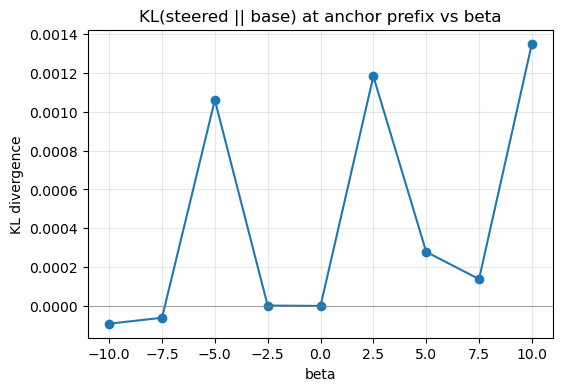

In [39]:
plt.figure(figsize=(6,4))
plt.plot(betas, kl_values, marker='o')
plt.axhline(0, color='gray', lw=0.5)
plt.title('KL(steered || base) at anchor prefix vs beta')
plt.xlabel('beta')
plt.ylabel('KL divergence')
plt.grid(True, alpha=0.3)
plt.show()